# Primer Paquete de Datos


In [1]:
print("hola")

hola


In [3]:
# sistema de archivos
import os
# funciones aleatorias
import random
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
from torchvision import transforms
from torchvision.ops import Permute
import torchvision.models as tvm
#redes
from torch.utils.data import DataLoader, random_split
# inspección de arquitectura
from torchsummary import summary
import matplotlib.pyplot as plt
# imágenes
from skimage import io
from skimage.transform import resize
from PIL import Image
from itertools import islice as take
import pandas as pd
from itertools import islice as take

from tqdm.auto import trange
from tqdm.auto import tqdm

## Utilidades

In [4]:
# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8

# tamaño del conjunto de entrenamiento (porcentaje)
TRN_SIZE = 0.8
NUM_WORKERS = 4 # hilos

# media y varianza de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]

def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
  """Displays examples in a grid."""
  fig, ax = plt.subplots(rows, cols, figsize=figsize)
  i = 0
  for r in range(rows):
      for c in range(cols):
          ax[r, c].imshow(xs[i], cmap='gray')
          ax[r, c].set_title(titles[i])
          ax[r, c].set_xticklabels([])
          ax[r, c].set_yticklabels([])
          i += 1
  fig.tight_layout()
  plt.show()

def display_batch(x, titles, rows, cols, figsize=(12, 6)):
  """Despliega un lote en una cuadrícula."""
  # denormalizamos
  for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
      x[:, c] = x[:, c] * std + mean 
  x *= 255
  # rotamos canales
  x = x.permute(0, 2, 3, 1)
  # convertimos a entero
  x = (x.numpy()).astype(np.uint8)
  # desplegamos lote
  display_grid(x, titles, rows, cols, figsize)

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def display_losses(losses):
  train_loss, test_loss = zip(*losses)
  plt.plot(train_loss,label='Entrenamiento')
  plt.plot(test_loss,label='Prueba')
  plt.xlabel('Época')
  plt.ylabel('Pérdida')
  plt.legend()
  plt.grid()
  plt.show()
def display_acc(accs):
  train_acc, test_acc = zip(*accs)
  plt.plot(train_acc,label='Entrenamiento')
  plt.plot(test_acc,label='Prueba')
  plt.xlabel('Época')
  plt.ylabel('Precisión')
  plt.legend()
  plt.grid()
  plt.show()

def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x


## Creación de los datasets

### Dividir el conjunto en 80% para entrenamiento y 20% para el test

In [5]:
data_dir= "ReduccionSinAumento"
images_names= os.listdir(data_dir)
print(len(images_names))
random.shuffle(images_names)
trn_names= [images_names[i::int(len(images_names))] for i in range(int(len(images_names)*0.8))]
tst_names= [images_names[i::int(len(images_names))] for i in range(int(len(images_names)*0.8), int(len(images_names)))]
print(len(trn_names))
print(len(tst_names))

1606
1284
322


In [6]:
trn_names = [item for items in trn_names for item in items]
tst_names = [item for items in tst_names for item in items]
tsfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
tst_tsfm = transforms.Compose([
    # convertimos a torch.Tensor
    transforms.ToTensor(),
    # Normalizamos
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

Funciones de apoyo

In [7]:
class PetrosDS:

    def __init__(self, root, trn_names, test_names, tsfm, flag):
          
        # guardamos la tranformación para las imágenes
        self.tsfm = tsfm
        
        # leemos el dataframe y filtramos columna healthy
        #df = pd.read_csv(os.path.join(root, 'trn.csv'), index_col='item')
        #df = df['healthy']
        
        # direcorios superiores
        #base_dir = os.path.join(root, 'trn')
        #classes = sorted(os.listdir(base_dir))
        
        # lista con las rutas a las imágenes
        self.paths = []
        # lista con las etiquetas de las imágenes
        self.labels = []
        # por cada clase
        images = trn_names if flag == True else test_names
        for name in images:
            # directorio de la clase
            #class_dir = os.path.join(base_dir, clazz)
            # nombres de los archivos en el directorio de la clase
            #names = sorted(os.listdir(class_dir))
            # guardamos los rutas y las etiquetas
            #for name in names:
            #print(str(name))
            self.labels.append(name.split('.')[0])
            self.paths.append(f'{root}/{name}')

    def __getitem__(self, i):
        # obtenemos la ruta de la imagen
        path = self.paths[i]
        # cargamos la imagen
        x = Image.open(path)
        # aplicamos transformación
        x = self.tsfm(x)
        # leeamos la etiqueta
        y = np.array(self.labels[i], np.int64)
        # regresamos el ejemplo
        return x, y

    def __len__(self):
        # número de ejemplos en el conjunto
        return len(self.paths)


In [8]:
trn_ds = PetrosDS(data_dir, trn_names, tst_names, tsfm,True)
tst_ds = PetrosDS(data_dir, trn_names, tst_names, tsfm,False)
print(trn_ds)



x shape=torch.Size([32, 3, 500, 500]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


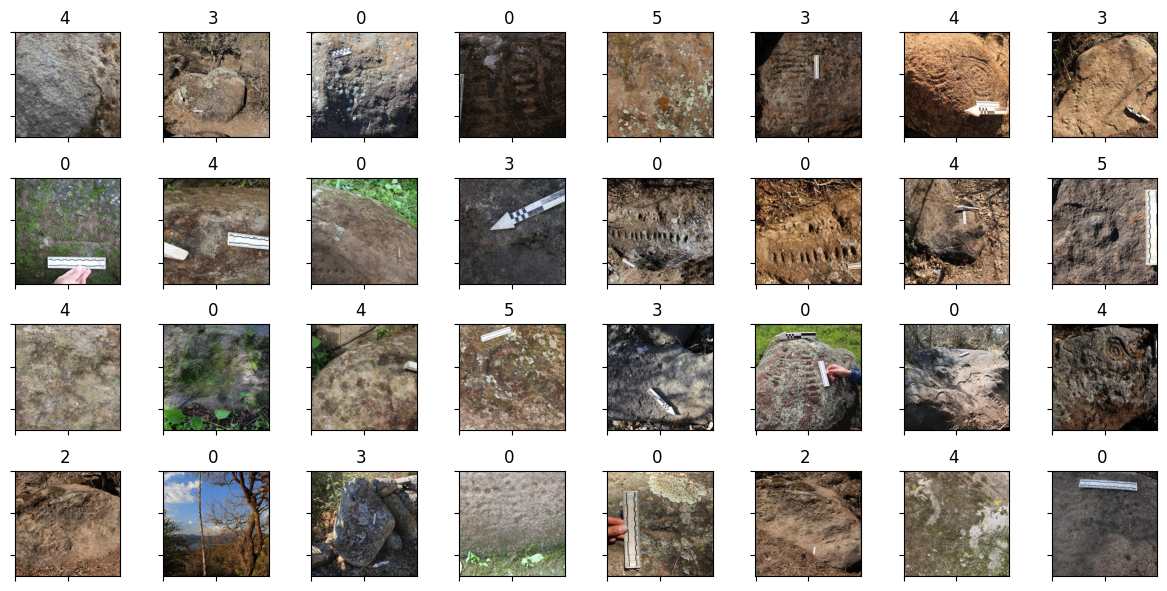

In [9]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
)
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()} '  for l in y]
display_batch(x, titles, ROWS, COLS)

In [10]:
for x, y in take(tst_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 3, 500, 500]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


## Modelos
Vamos a usar distintos modelos para el entrenamiento

In [11]:
modelo_alexnet = tvm.alexnet(pretrained=True)
summary(modelo_alexnet, (3, 500, 500), device='cpu', verbose=0)

C:\Users\Paris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Paris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 64, 124, 124]        23,296
|    └─ReLU: 2-2                         [-1, 64, 124, 124]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 61, 61]          --
|    └─Conv2d: 2-4                       [-1, 192, 61, 61]         307,392
|    └─ReLU: 2-5                         [-1, 192, 61, 61]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 30, 30]         --
|    └─Conv2d: 2-7                       [-1, 384, 30, 30]         663,936
|    └─ReLU: 2-8                         [-1, 384, 30, 30]         --
|    └─Conv2d: 2-9                       [-1, 256, 30, 30]         884,992
|    └─ReLU: 2-10                        [-1, 256, 30, 30]         --
|    └─Conv2d: 2-11                      [-1, 256, 30, 30]         590,080
|    └─ReLU: 2-12                        [-1, 256, 30, 30]   

In [12]:
#Updating the second classifier
modelo_alexnet.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
modelo_alexnet.classifier[6] = nn.Linear(1024,7)
summary(modelo_alexnet, (3, 500, 500), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 64, 124, 124]        23,296
|    └─ReLU: 2-2                         [-1, 64, 124, 124]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 61, 61]          --
|    └─Conv2d: 2-4                       [-1, 192, 61, 61]         307,392
|    └─ReLU: 2-5                         [-1, 192, 61, 61]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 30, 30]         --
|    └─Conv2d: 2-7                       [-1, 384, 30, 30]         663,936
|    └─ReLU: 2-8                         [-1, 384, 30, 30]         --
|    └─Conv2d: 2-9                       [-1, 256, 30, 30]         884,992
|    └─ReLU: 2-10                        [-1, 256, 30, 30]         --
|    └─Conv2d: 2-11                      [-1, 256, 30, 30]         590,080
|    └─ReLU: 2-12                        [-1, 256, 30, 30]   

## Entrenamiento

In [16]:
# obtenemos dispositivo en gpu, si no en cpu
#device = torch.device('cpu')
#device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
def train_epoch(data_loader,model,opt,epoch):
  # para cada lote
  for x, y_true in data_loader:
    x = x.to(device)
    #y_true = y_true.flatten()
    
    #y_true = y_true.type(torch.LongTensor)
    y_true = y_true.to(device)
    #print(y_true)  
    #y_true = y_true.to(device)
    # inferencia
    #print(y_true.type())
    y_lgts = model(x)
    #print(y_lgts.size())
    y_prob = F.softmax(y_lgts, 1)
    #print(y_prob.size())
    y_hat = torch.argmax(y_prob, 1)
    loss = F.cross_entropy(y_lgts, y_true)
    # backprop
    opt.zero_grad() # vaciamos los gradientes
    loss.backward() # retropropagamos
    opt.step() # actualizamos parámetros

def eval_epoch(data_loader, model, epoch):
  # Para la evaluación evitamos que se regsitren las operaciones
  with torch.no_grad():
    
    losses = []
    accs= []
    for x, y_true in data_loader:
      x = x.to(device)
      y_true = y_true.to(device)
      y_lgts = model(x) # Evaluamos
      y_prob = F.softmax(y_lgts, 1)
      y_hat = torch.argmax(y_prob, 1)
      loss_b = F.cross_entropy(y_lgts, y_true) # Calculamos la pérdida
      acc = (y_true == y_hat).type(torch.float32).mean()
      losses.append(loss_b.item())
      accs.append(acc.item() * 100)
    
    loss = np.mean(losses)
    acc = np.mean(accs)
    return loss, acc

def train(model, train_dl, test_dl,epochs=10,lr=1e-3,opt='Adam',
          transfer_learning = False,full_train=False,
          L2lambda=0,progress=True):
  
  model = model.to(device)
  loss_hist = []
  acc_hist= []
  # optimizadores
  if opt == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=L2lambda)
  if opt == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(),lr=lr, weight_decay=L2lambda)
  if opt == 'Adam':
    optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=L2lambda)

  # Congelamos loss parámetros
  #if transfer_learning:
  #  freeze = not full_train # si no se quiere reentrenar toda la red, se congelan los parametros
  #  model.freeze_features(freeze)

  # Para imprimir el progreso
  range_progress = trange(epochs)  if progress else range(epochs)

  model.eval()

  # ciclo de entrenamiento
  for epoch in range_progress:
    # Entrenamiento
    model.train()
    train_epoch(train_dl,model,optimizer,epoch)

    # Evaluación
    model.eval()
    train_loss, train_acc = eval_epoch(train_dl, model, epoch)
    test_loss, test_acc = eval_epoch(test_dl, model, epoch)
  
    loss_hist.append([train_loss,test_loss])
    acc_hist.append([train_acc,test_acc])
    if progress:
      print(f'E{epoch:02} '
            f'loss=[{train_loss:6.2f},{test_loss:6.2f}]'f'acc=[{train_acc:6.2f},{test_acc:6.2f}]')
      
  return loss_hist, acc_hist

In [21]:
loss1, acc1= train(modelo_alexnet, trn_dl, tst_dl,epochs=30,lr=1e-4,opt='Adam',
          transfer_learning = True,progress=True)


  3%|▎         | 1/30 [00:14<06:46, 14.03s/it]

E00 loss=[  0.02,  0.99]acc=[ 99.47, 80.40]


  7%|▋         | 2/30 [00:27<06:25, 13.76s/it]

E01 loss=[  0.04,  0.79]acc=[ 98.63, 82.10]


 10%|█         | 3/30 [00:40<05:58, 13.28s/it]

E02 loss=[  0.01,  0.77]acc=[ 99.92, 85.23]


 13%|█▎        | 4/30 [00:53<05:39, 13.06s/it]

E03 loss=[  0.00,  0.77]acc=[100.00, 86.93]


 17%|█▋        | 5/30 [01:05<05:23, 12.95s/it]

E04 loss=[  0.00,  1.16]acc=[100.00, 75.85]


 20%|██        | 6/30 [01:18<05:08, 12.84s/it]

E05 loss=[  0.00,  1.34]acc=[ 99.92, 84.94]


 23%|██▎       | 7/30 [01:31<04:54, 12.82s/it]

E06 loss=[  0.05,  0.99]acc=[ 98.93, 82.67]


 27%|██▋       | 8/30 [01:44<04:42, 12.82s/it]

E07 loss=[  0.01,  1.38]acc=[ 99.92, 80.68]


 30%|███       | 9/30 [01:56<04:28, 12.77s/it]

E08 loss=[  0.00,  0.99]acc=[100.00, 83.24]


 33%|███▎      | 10/30 [02:09<04:15, 12.76s/it]

E09 loss=[  0.00,  0.83]acc=[100.00, 86.93]


 37%|███▋      | 11/30 [02:22<04:02, 12.76s/it]

E10 loss=[  0.00,  0.71]acc=[100.00, 88.35]


 40%|████      | 12/30 [02:34<03:49, 12.76s/it]

E11 loss=[  0.00,  1.41]acc=[100.00, 83.81]


 43%|████▎     | 13/30 [02:47<03:36, 12.76s/it]

E12 loss=[  0.00,  1.03]acc=[100.00, 85.51]


 47%|████▋     | 14/30 [03:00<03:23, 12.71s/it]

E13 loss=[  0.00,  0.87]acc=[100.00, 87.22]


 50%|█████     | 15/30 [03:12<03:10, 12.70s/it]

E14 loss=[  0.00,  1.57]acc=[100.00, 78.12]


 53%|█████▎    | 16/30 [03:25<02:58, 12.72s/it]

E15 loss=[  0.00,  0.76]acc=[100.00, 88.92]


 57%|█████▋    | 17/30 [03:38<02:45, 12.70s/it]

E16 loss=[  0.00,  1.03]acc=[100.00, 83.52]


 60%|██████    | 18/30 [03:51<02:32, 12.68s/it]

E17 loss=[  0.00,  1.03]acc=[100.00, 84.66]


 63%|██████▎   | 19/30 [04:03<02:19, 12.70s/it]

E18 loss=[  0.01,  1.21]acc=[ 99.77, 83.81]


 67%|██████▋   | 20/30 [04:16<02:07, 12.71s/it]

E19 loss=[  0.06,  0.88]acc=[ 98.09, 82.10]


 70%|███████   | 21/30 [04:29<01:54, 12.70s/it]

E20 loss=[  0.01,  1.22]acc=[ 99.70, 73.86]


 73%|███████▎  | 22/30 [04:41<01:41, 12.73s/it]

E21 loss=[  0.03,  0.86]acc=[ 99.24, 82.39]


 77%|███████▋  | 23/30 [04:54<01:28, 12.71s/it]

E22 loss=[  0.00,  1.11]acc=[100.00, 80.68]


 80%|████████  | 24/30 [05:07<01:16, 12.76s/it]

E23 loss=[  0.00,  0.80]acc=[100.00, 86.93]


 83%|████████▎ | 25/30 [05:20<01:04, 12.84s/it]

E24 loss=[  0.00,  0.83]acc=[100.00, 86.08]


 87%|████████▋ | 26/30 [05:33<00:52, 13.00s/it]

E25 loss=[  0.00,  0.86]acc=[100.00, 86.93]


 90%|█████████ | 27/30 [05:46<00:38, 12.93s/it]

E26 loss=[  0.00,  0.83]acc=[100.00, 86.65]


 93%|█████████▎| 28/30 [05:59<00:25, 12.77s/it]

E27 loss=[  0.00,  0.92]acc=[100.00, 83.52]


 97%|█████████▋| 29/30 [06:11<00:12, 12.63s/it]

E28 loss=[  0.00,  0.82]acc=[100.00, 87.78]


100%|██████████| 30/30 [06:23<00:00, 12.79s/it]

E29 loss=[  0.00,  0.88]acc=[100.00, 85.80]


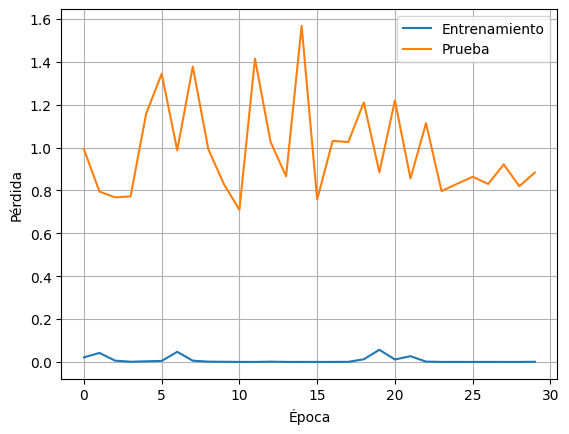

In [22]:
display_losses(loss1)

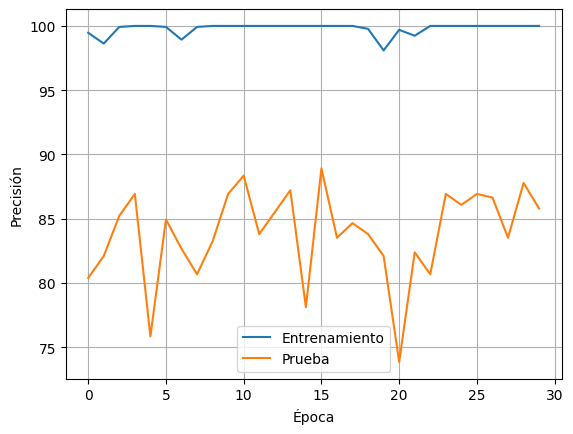

In [23]:
display_acc(acc1)